<hr>

# PREDICTING THE STOCK MARKET WITH WATSON

## Part I: Introduction

In this Jupyter Notebook you will learn step-by-step how to extract financial data from one of the most popular public databases for econometric data, as well as the cleansing and preparation processes of the data science traditional workflow.

After preparing the data into an adequate format, structured into a pandas dataframe, we train a predictive model utilizing techniques such as curve-fitting and ARIMA (AutoRegressive Integrated Moving Average).

Lastly, we create interactive plots to visualize the collected data, as well as the results of the forecasters trained.

## Table of Contents

#### 1. Mining Stock Market Data
* 1.1. Quandl API Setup
* 1.2. Downloading the WIKI/PRICES Table
* 1.3. Visualizing the Collected Data

#### 2. Training a Predictive Model using Open-Source Libraries
* 2.1. Fbprophet Setup
* 2.2. Data Preparation
* 2.3. The Machine Learning

####  3. Analyzing the Results
* 3.1. Analyzing Seasonalities
* 3.2. Overlapping of Actual Values with Expected Values
* 3.3. Trained Model Evaluation

#### 4. Exporting Data
* 4.1. Exporting Data to IBM Cloud Object Storage

<hr>

# 1: Mining Stock Market Data

The data mining step is done using the Quandl API, a financial database (with both public and private tables) purchased by NASDAQ in 2018. It is not mandatory to use an API key to extract data, however it is recommended to generate one for free <a href="https://www.quandl.com/">at the Quandl website</a>.

### 1.1: Quandl API Setup

In [1]:
# Install quandl package (this can take some minutes)
!pip install --user quandl==3.4.8 --upgrade

     |████████████████████████████████| 81kB 7.9MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/9f/5a/d3/6fc3bf6516d2a3eb7e18f9f28b472110b59325f3f258fe9211
Successfully built inflection
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
# Import quandl package
import quandl
print("Quandl package imported.")

Quandl package imported.


If you registered and generated an API key for free on the Quandl web page, type it in the variable in the cell below.

In [3]:
quandl.ApiConfig.api_key = ""

### 1.2: Downloading the WIKI/PRICES Table

Quandl has several public and private data tables available.

In this project we will use the table <a href="https://www.quandl.com/databases/WIKIP"> WIKI/PRICES</a>. This table has information on the daily closing and opening values of the shares of more than 3000 companies.

The data download is done via an API call executed with the quandl library, using the `get_table` function. The arguments of this function are: the table name, the <a href="https://en.wikipedia.org/wiki/Ticker_symbol"> ticker symbol </a> of the desired stock, and the desired columns of the table. The `paginate=True` parameter allows more than 10000 rows of data to be transferred with a single call.

The result of this function call is a pandas dataframe with the desired stock data, ready to be transformed.

In [4]:
# API Call example - Downloading financial data from IBM stocks
data = quandl.get_table('WIKI/PRICES',
                        ticker='IBM', 
                        qopts={'columns':['date', 'open', 'high', 'low', 'close']},
                        paginate=True)

At the <a href="https://www.nasdaq.com/symbol/">NASDAQ page</a> you can see the ticker symbols for various stocks.

You can also choose a ticker from the ones listed in the `nasdaq-ticker-table.csv` file, which can be accessed <a href ="https://github.com/vanderleipf/ibmdegla-ws-projects/blob/master/EN-US/forecasting-the-stock-market/data/stock-ticker-table.csv">here</a>.

Choose the ticker of another company, or use the data already configured and saved in the dataframe `date` by the API call executed in the above code cell.

In [5]:
# Renaming the pandas dataframe columns
data.columns = ['Date', 'Open', 'High', 'Low', 'Close']

# Reset the pandas dataframe index
data = data.reset_index(drop=True)

# Show the last five rows of the pandas dataframe
data.tail()

,Date,Open,High,Low,Close
14150,1962-01-08,559.5,559.5,545.0,549.50
14151,1962-01-05,570.5,570.5,559.0,560.00
14152,1962-01-04,577.0,577.0,571.0,571.25
14153,1962-01-03,572.0,577.0,572.0,577.00
14154,1962-01-02,578.5,578.5,572.0,572.00


### 1.3: Visualizing the Collected Data

To view the data, the `bokeh` package is used. This module is capable of generating interactive Javascript charts.

In [6]:
!pip install --user bokeh==1.0.4 --upgrade

Requirement already up-to-date: bokeh==1.0.4 in /opt/conda/envs/Python36/lib/python3.6/site-packages (1.0.4)


In [7]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource
from bokeh.embed import components
from bokeh.io import output_notebook

print('Packages imported.')

Packages imported.


In [8]:
# Load bokeh
output_notebook()

Loading BokehJS ...

In [9]:
# Bokeh Figure
p = figure(plot_width=1200, plot_height=550, title='Stock Value Historical Data', x_axis_type="datetime")

# Plot Lines
p.line(data.Date, data.Open, line_width=2, line_color="#0099ff", legend='Open')
p.line(data.Date, data.Close, line_width=2, line_color="#ff6699", legend='Close')
p.line(data.Date, data.High, line_width=1, line_color="#000000", legend='High')
p.line(data.Date, data.Low, line_width=1, line_color="#000000", legend='Low')

# Axis and Labels
p.legend.orientation = "vertical"
p.xaxis.axis_label = "Date"
p.xaxis.axis_label_text_font_style = 'bold'
p.xaxis.axis_label_text_font_size = '16pt'
p.xaxis.major_label_text_font_size = '14pt'
p.yaxis.axis_label = "Value ($ USD)"
p.yaxis.axis_label_text_font_style = 'bold'
p.yaxis.axis_label_text_font_size = '16pt'
p.yaxis.major_label_text_font_size = '12pt'

In the figure below we can see and interact with the data extracted from the WIKI/PRICES table. In blue we have the opening value of the stock; in red the closing value of the stock; in black we have the maximum and minimum values (daily).

In [10]:
show(p)

<hr>

# 2: Training a Predictive Model using Open-Source Libraries

In the training process of our predictive model, we will use the `fbprophet` package, developed by Facebook for time series analysis.

Fbprophet follows the same style of objects as `sklearn`, an extremely popular machine learning python library. An instance of the Prophet class is created and then the `fit` and` predict` methods are used.

The training set of a Prophet model is a two-column pandas dataframe with the columns `ds` and` y`. The `ds` (datestamp) column must be a date in the format YYYY-MM-DD, or a timestamp in the format YYYY-MM-DD HH:MM:SS. The `y` column must be numeric, and represents the variable we wish to model in the future.

### 2.1: Fbprophet Setup

In [11]:
# Install required packages (this can take some minutes)
# UPDATE(vnderlev): setuptools-git is now required for fbprophet 0.5. 
!pip install --user pystan==2.17.1.0 holidays==0.9.8 setuptools-git==1.2 --upgrade

     |████████████████████████████████| 68.1MB 51.9MB/s eta 0:00:01�████████████████            | 42.7MB 8.0MB/s eta 0:00:04
     |████████████████████████████████| 71kB 27.9MB/s eta 0:00:01
     |████████████████████████████████| 14.7MB 42.8MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/6f/d2/1a/5854fb5211d237db046d9ae62674a112d020d84c40a729dd02
Successfully built holidays


In [12]:
# Install fbprophet from conda-forge (this will take some time, please be patient)
!conda install -c conda-forge matplotlib=3.0.2 fbprophet=0.5 -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - fbprophet=0.5
    - matplotlib=3.0.2


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    gcc_impl_linux-64-7.3.0    |       habb00fd_1        73.2 MB
    pystan-2.17.1.0            |py36hf2d7682_1004        14.0 MB  conda-forge
    matplotlib-3.0.2           |        py36_1002           6 KB  conda-forge
    lunardate-0.2.0            |             py_0          21 KB  conda-forge
    holidays-0.9.11            |             py_0          39 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    convertdate-2.1.3          |          py_1000          30 KB  conda-forge
    binutils_impl_linux-64-2.33.1|       h53a641e_8         9.1 MB  conda-forge
    ephem-3.7.7.0              |   py36h516909a_0         727 KB  conda-for

In [13]:
# Import packages
import fbprophet
import datetime as dt

print('Packages imported.')

Packages imported.


### 2.2: Data Preparation

First of all, the previously collected dataframe needs to be prepared.

The preparation includes the selection of a subset of the data for model training. In this Jupyter notebook we will only sample the latest data, starting from 2008.

Of the four columns with stock values, only one column will be chosen as the variable of interest. We will choose the daily opening value of the shares (the `Open` column).

In [14]:
# Select train sample
df_train = data.copy()
df_train = df_train[(df_train.Date > dt.datetime(2008,1,1))]
df_train.tail()

,Date,Open,High,Low,Close
2571,2008-01-08,100.050,100.38,97.17,97.59
2572,2008-01-07,100.355,101.00,99.03,100.05
2573,2008-01-04,103.950,103.95,100.48,101.13
2574,2008-01-03,104.410,105.57,103.98,104.90
2575,2008-01-02,108.990,108.99,104.17,104.69


In [15]:
# Format the dataframe for FBProphet
df_train.rename(columns={'Open':'y', 'Date':'ds'}, inplace=True)
df_train = df_train.filter(items=['ds', 'y'])
df_train.tail()

,ds,y
2571,2008-01-08,100.050
2572,2008-01-07,100.355
2573,2008-01-04,103.950
2574,2008-01-03,104.410
2575,2008-01-02,108.990


### 2.3: The Machine Learning

As previously mentioned, Prophet uses the same interface style as the sklearn library.

A Prophet class is instantiated, with the desired types of seasonality. For this work, we will consider annual and monthly seasonalities in stock values, and disregard daily and weekly effects.

Usually the presented settings are the most adequate for stock prediction, but feel free to test different seasonalities.

In [18]:
# Instantiate a fbprophet model
model = fbprophet.Prophet(daily_seasonality=False,
                weekly_seasonality=False, 
                yearly_seasonality=True,
                changepoint_prior_scale=0.05,
                changepoints=None)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

In [19]:
# Train model
model.fit(df_train)

/home/dsxuser/.local/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In the following cell, the prediction runs in a period of 365 days (1 year) in the future. The result is a multi-column dataframe with information about trends, tolerances, and forecasts.

In [20]:
# Execute forecasting algorithm (1 year into the future)
future_data = model.make_future_dataframe(periods=365, freq='D')
future_data = model.predict(future_data)
future_data.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2936,2019-03-23,167.857700,149.366137,192.776696,147.191450,186.363058,3.307832,3.307832,3.307832,-0.303869,-0.303869,-0.303869,3.611701,3.611701,3.611701,0.0,0.0,0.0,171.165531
2937,2019-03-24,167.875086,149.253144,192.335314,147.124865,186.440229,3.488793,3.488793,3.488793,-0.324944,-0.324944,-0.324944,3.813737,3.813737,3.813737,0.0,0.0,0.0,171.363879
2938,2019-03-25,167.892472,149.122337,191.092729,147.066623,186.469597,3.891269,3.891269,3.891269,-0.118951,-0.118951,-0.118951,4.010220,4.010220,4.010220,0.0,0.0,0.0,171.783741
2939,2019-03-26,167.909858,148.291876,193.763009,147.016326,186.532310,4.279897,4.279897,4.279897,0.080996,0.080996,0.080996,4.198901,4.198901,4.198901,0.0,0.0,0.0,172.189755
2940,2019-03-27,167.927244,149.579537,193.795205,146.976656,186.633860,4.410317,4.410317,4.410317,0.032757,0.032757,0.032757,4.377559,4.377559,4.377559,0.0,0.0,0.0,172.337561


<hr>

## 3: Results

### 3.1: Analyzing Seasonalities

]In the figure below we have a quick plot of the results using the Prophet class `plot` method.

The black dots are the actual data, the dark blue line is the modeled trend, and in light blue we have the tolerance (minimum and maximum values modeled).

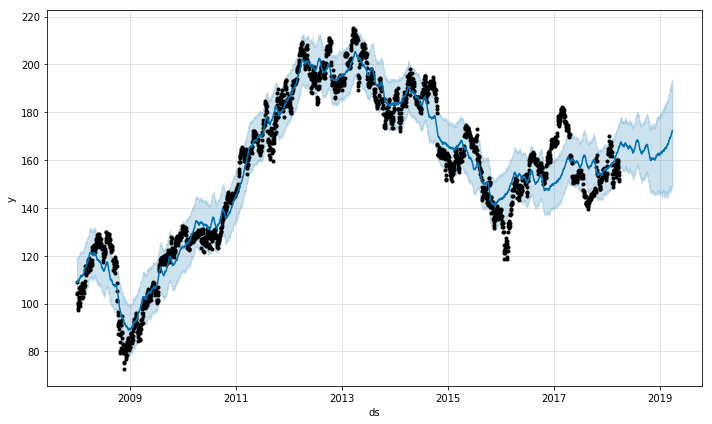

In [21]:
fig1 = model.plot(future_data)

Using the `plot_components` function of the Prophet object, we can also analyze trend information, as well as the monthly and yearly seasonalities considered in the modeling.

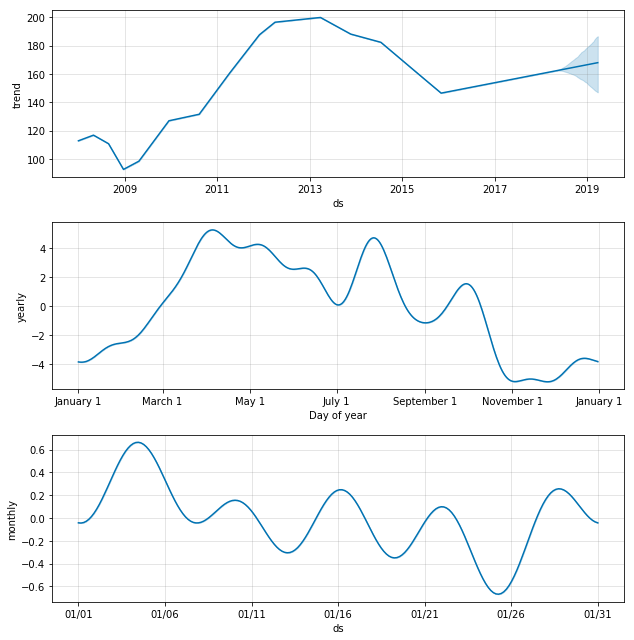

In [22]:
fig2 = model.plot_components(future_data)

### 3.2: Overlapping of Actual Values with Expected Values

In [23]:
# Bokeh Figure
p = figure(plot_width=1200, plot_height=550, title='Stock Value Historical Data', x_axis_type="datetime")

# Plot Lines
p.line(data[data['Date'] > dt.datetime(2008,1,1)].Date, data[data['Date'] > dt.datetime(2008,1,1)].Open, line_width=2, line_color="#0099ff", legend='Observed Open Value')
p.line(future_data.ds, future_data.yhat, line_width=2, line_color="#2B0000", legend='Modeled Open Value')
p.line(future_data.ds, future_data.yhat_upper, line_width=0.5, line_color="#000099", legend='Upper Estimates')
p.line(future_data.ds, future_data.yhat_lower, line_width=0.5, line_color="#000099", legend='Lower Estimates')

# Axis and Labels
p.legend.orientation = "vertical"
p.xaxis.axis_label = "Date"
p.xaxis.axis_label_text_font_style = 'bold'
p.xaxis.axis_label_text_font_size = '16pt'
p.xaxis.major_label_text_font_size = '14pt'
p.yaxis.axis_label = "Value ($ USD)"
p.yaxis.axis_label_text_font_style = 'bold'
p.yaxis.axis_label_text_font_size = '16pt'
p.yaxis.major_label_text_font_size = '12pt'

In the next cell we can thoroughly analyze the quality of the trained model by comparing the modeled values (in black) with the actual observed values (light blue).

In [24]:
show(p)

### 3.3: Trained Model Evaluation

The Prophet class also provides the means to perform an evaluation of the created model.

The `cross-validation` method will be used to evaluate our model.

In [25]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')
df_cv.head()

INFO:fbprophet:Making 15 forecasts with cutoffs between 2010-05-03 00:00:00 and 2017-03-27 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2010-05-04,130.125353,126.696520,133.585439,128.89,2010-05-03
1,2010-05-05,129.849046,126.553830,133.655054,127.12,2010-05-03
2,2010-05-06,129.896752,126.513108,133.589868,126.29,2010-05-03
3,2010-05-07,130.086849,126.736307,133.353076,123.36,2010-05-03
4,2010-05-10,128.465632,124.951333,131.971786,126.27,2010-05-03


In [26]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
0,37 days,93.917284,9.691093,8.098506,0.048515,0.407282
1,38 days,94.464600,9.719290,8.116347,0.048627,0.409453
2,39 days,95.461931,9.770462,8.151825,0.048875,0.409211
3,40 days,98.132013,9.906160,8.275073,0.049647,0.401495
4,41 days,100.302406,10.015109,8.387325,0.050319,0.396552


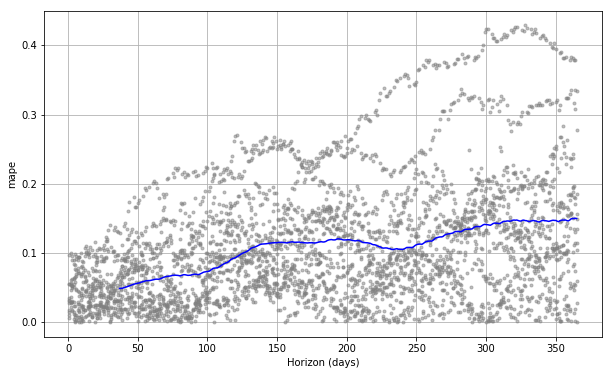

In [27]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

Analyzing the `MAPE` criterion projected in the cell above, it is noticed that the error for a forecast of up to 50 days turns around 5%, reaching 15% for a forecast of 365 days. This error is a relatively good metric if the objective is to construct an image of the market trends. For day-trading purposes, even 95% accuracy is not really adequate.

<hr>

# 4: Exporting Data

### 4.1: Exporting Data to IBM Cloud Object Storage

The mined data, as well as the data produced by the model, can be exported as CSV files to IBM Cloud Object Storage, and eventually be used or published in other applications.

Next we present the code necessary to perform this task in an automated way.

In [28]:
from ibm_botocore.client import Config
import ibm_boto3, os

print('Packages imported.')

Packages imported.


Set up your IBM Cloud Object Storage credentials in the next cell.

In [30]:
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
cos_credentials = {
    'IAM_SERVICE_ID': '',
    'IBM_API_KEY_ID': '',
    'ENDPOINT': '',
    'IBM_AUTH_ENDPOINT': '',
    'BUCKET': '',
    'FILE': ''
}


The `upload_data_to_ibm_cos` is a function created to upload pandas dataframes as CSV files in IBM COS.

In [31]:
def upload_data_to_ibm_cos(credentials, df, df_future, tick):
    cos = ibm_boto3.client(service_name='s3', 
                           ibm_api_key_id=credentials['IBM_API_KEY_ID'], 
                           ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
                           ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
                           config=Config(signature_version='oauth'),
                           endpoint_url=credentials['ENDPOINT'])
    df.to_csv('{}.csv'.format(tick), sep=',', encoding='utf-8')
    df_future.to_csv('{}_future.csv'.format(tick), sep=',', encoding='utf-8')
    try:
        res=cos.upload_file(Filename='{}.csv'.format(tick), Bucket=credentials['BUCKET'], Key='{}.csv'.format(tick))
        res=cos.upload_file(Filename='{}_future.csv'.format(tick), Bucket=credentials['BUCKET'], Key='{}_future.csv'.format(tick))
    except Exception as e:
        print(Exception, e)
    else:
        print("{} data uploaded to IBM COS.".format(tick))
        os.remove('{}.csv'.format(tick))
        os.remove('{}_future.csv'.format(tick))

In [32]:
# Upload mined and modeled data to IBM COS
upload_data_to_ibm_cos(cos_credentials, data, future_data, 'IBM')

INFO:ibm_botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): iam.ng.bluemix.net


IBM data uploaded to IBM COS.


You can now access the `<stock_ticker>.csv` and `<stock_ticker>_future.csv` file anywhere using the IBM COS API.

<hr>


## Want to Learn More?

Watch the public video on how to replicate this analysis with SPSS Modeler, an analytics platform that has several embedded machine learning algorithms. This platform is designed to facilitate data analysis through a graphical programming language, and is integrated with Watson Studio.

This notebook and its source code is made available under the terms of the <a href = "https://github.com/IBM/watson-stock-market-predictor/blob/master/LICENSE">Apache License 2.0</a>.

<hr>

### Thank you for completing this journey!